In [1]:
from pathlib import Path
import pandas as pd
from keras.layers import BatchNormalization, Dense, Input, Conv1D, Add, ELU, Flatten, MaxPooling1D
from keras.layers import GlobalAveragePooling1D, Softmax, Concatenate, Reshape, Multiply, ReLU
from keras.optimizers import SGD
from keras import activations
from keras import Model
from keras.initializers import HeNormal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from load_dataset import load_original_daic, load_labels
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.vis_utils import plot_model

In [2]:
daic_pose_train = load_original_daic("original_daic/train", "pose")
daic_pose_dev = load_original_daic("original_daic/dev", "pose")
daic_pose_test = load_original_daic("original_daic/test", "pose")

daic_lm_train = load_original_daic("original_daic/train", "features")
daic_lm_dev = load_original_daic("original_daic/dev", "features")
daic_lm_test = load_original_daic("original_daic/test", "features")

In [3]:
label_path = Path("original_daic/labels")
loaded_labels = load_labels(label_path)
y_train = np.array(loaded_labels["train"])
y_dev = np.array(loaded_labels["dev"])
y_test = np.array(loaded_labels["test"])

In [4]:
pose_train = []
pose_dev = []
pose_test = []
for subject_id, subject_df in daic_pose_train.items():
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    pose_train.append(temp)
for subject_id, subject_df in daic_pose_dev.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    pose_dev.append(temp)
for subject_id, subject_df in daic_pose_test.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    pose_test.append(temp)

In [5]:
lm_train = []
lm_dev = []
lm_test = []
for subject_id, subject_df in daic_lm_train.items():
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    lm_train.append(temp)
for subject_id, subject_df in daic_lm_dev.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    lm_dev.append(temp)
for subject_id, subject_df in daic_lm_test.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    lm_test.append(temp)

In [6]:
all_pose_samples = pose_train + pose_dev + pose_test
# all_samples = np.array(pose_train + pose_dev + pose_test, dtype=object)
all_pose_samples = np.concatenate((all_pose_samples),)
# all_samples.shape
pose_min_values = all_pose_samples.min(axis=0)
pose_ptp_ranges = all_pose_samples.ptp(axis=0)

all_lm_samples = lm_train + lm_dev + lm_test
# all_samples = np.array(pose_train + pose_dev + pose_test, dtype=object)
all_lm_samples = np.concatenate((all_lm_samples),)
# all_samples.shape
lm_min_values = all_lm_samples.min(axis=0)
lm_ptp_ranges = all_lm_samples.ptp(axis=0)

In [7]:
pose_train = np.array(pose_train)
pose_dev = np.array(pose_dev)
pose_test = np.array(pose_test)

lm_train = np.array(lm_train)
lm_dev = np.array(lm_dev)
lm_test = np.array(lm_test)

In [8]:
norm_pose_train = (pose_train - pose_min_values)/pose_ptp_ranges
norm_pose_dev = (pose_dev - pose_min_values)/pose_ptp_ranges
norm_pose_test = (pose_test - pose_min_values)/pose_ptp_ranges

norm_lm_train = (lm_train - lm_min_values)/lm_ptp_ranges
norm_lm_dev = (lm_dev - lm_min_values)/lm_ptp_ranges
norm_lm_test = (lm_test - lm_min_values)/lm_ptp_ranges

In [9]:
input_pose = Input(shape=[5000, 6])
tdcn_dim_pose = [128,64,256,128,64] # used in Guo's paper
# tdcn_dim_pose = [128,128,128,128,128]
input_lm = Input(shape=[5000, 136])
tdcn_dim_lm = [256,256,128,64,64] # used in Guo's paper
# tdcn_dim_lm = [256,256,256,256,256]
bias_initializer = HeNormal(seed=0)

In [10]:
x_train_bad = np.concatenate((np.zeros((200, 5000, 6)), np.ones((200, 5000, 6))))
y_train_bad = np.concatenate((np.zeros(200), np.ones(200)))
x_dev_bad = np.concatenate((np.zeros((20, 5000, 6)), np.ones((20, 5000, 6))))
y_dev_bad = np.concatenate((np.zeros(20), np.ones(20)))
print(x_train_bad.shape)
print(y_train_bad.shape)

(400, 5000, 6)
(400,)


In [11]:
# One DCB
# first layer of the DCB
def diluted_conv_block(inputs, feature_dim):
    # with K.name_scope(block_name)
    l1_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_add = Add()([l1_p1, l1_p2])
    l1_ELU = ELU()(l1_add)
    # second layer of the DCB
    l2_p1 = Conv1D(filters=feature_dim, kernel_size=5, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_p2 = Conv1D(filters=feature_dim, kernel_size=5, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_add = Add()([l2_p1, l2_p2])
    l2_ELU = ELU()(l2_add)
    # third layer of the DCB
    l3_p1 = Conv1D(filters=feature_dim, kernel_size=9, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_p2 = Conv1D(filters=feature_dim, kernel_size=9, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_add = Add()([l3_p1, l3_p2])
    l3_ELU = ELU()(l3_add)

    residual = Conv1D(filters=feature_dim, kernel_size=1, padding="same")(inputs)
    res_add = Add()([l3_ELU, residual])
    # res_add = Add()([l1_ELU, residual])
    # res_add = ELU()(res_add)
    bn = BatchNormalization()(res_add)
    return bn
    # return residual

In [15]:
def time_diluted_conv_net(feature_dim, input_layer, pool_size, pool_stride):
    dcb_1 = diluted_conv_block(input_layer, feature_dim[0])
    mp_1 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_1)
    dcb_2 = diluted_conv_block(mp_1, feature_dim[1])
    mp_2 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_2)
    dcb_3 = diluted_conv_block(mp_2, feature_dim[2])
    mp_3 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_3)
    dcb_4 = diluted_conv_block(mp_3, feature_dim[3])
    mp_4 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_4)
    dcb_5 = diluted_conv_block(mp_4, feature_dim[4])
    return dcb_5
    # return dcb_2

# TDCN block for pose
tdcn_pose = time_diluted_conv_net(
    feature_dim = tdcn_dim_pose, 
    input_layer = input_pose, 
    pool_size = 2, 
    pool_stride = 2,
    )

# TDCN block for landmarks
tdcn_lm = time_diluted_conv_net(
    feature_dim = tdcn_dim_lm, 
    input_layer = input_lm, 
    pool_size = 2, 
    pool_stride = 2,
    )

# FWA block
concat_layer = Concatenate()([tdcn_pose, tdcn_lm])
# print(concat_layer.shape)
gap_layer = GlobalAveragePooling1D(data_format="channels_last")(concat_layer)
# print(gap_layer.shape)

linear_layer_1 = Dense(gap_layer.shape[1])(gap_layer)
relu_layer = activations.relu(linear_layer_1)
linear_layer_2 = Dense(gap_layer.shape[1])(relu_layer)
sigmoid_layer = activations.sigmoid(linear_layer_2)
elementwise_product = Multiply()([concat_layer, sigmoid_layer])
print(elementwise_product.shape)
# FC layer
flatten = Flatten()(elementwise_product)
print(flatten.shape)
FC_l1 = Dense(300, activation="relu")(flatten)
FC_l2 = Dense(300, activation="relu")(FC_l1)
FC_l3 = Dense(100, activation="relu")(FC_l2)
last_layer = Dense(2, activation="sigmoid")(FC_l3)
output = Softmax()(last_layer)
# output = Dense(1, activation = "sigmoid")(FC_l3)

(None, 312, 128)
(None, 39936)


In [16]:
model_pose_lm = Model(inputs=[input_pose, input_lm], outputs=[output])
opt = SGD(learning_rate = 2e-5, momentum = 0.9)
# model_pose_lm.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])
model_pose_lm.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [17]:
# model_pose.fit(x_train_bad[:], y_train_bad[:], validation_data=(x_dev_bad[:], y_dev_bad[:]), epochs=2)
model_pose_lm.fit([pose_train[:], lm_train[:]], y_train[:], validation_data=([pose_dev[:], lm_dev[:]], y_dev[:]), epochs=10, batch_size=8)

Epoch 1/10
14/14 [==============================] - 68s 5s/step - loss: 0.7001 - accuracy: 0.4673 - val_loss: 0.9194 - val_accuracy: 0.3714
Epoch 2/10
14/14 [==============================] - 90s 7s/step - loss: 0.6955 - accuracy: 0.5514 - val_loss: 0.8890 - val_accuracy: 0.3714
Epoch 3/10
14/14 [==============================] - 64s 5s/step - loss: 0.6881 - accuracy: 0.5421 - val_loss: 0.7549 - val_accuracy: 0.3429
Epoch 4/10
14/14 [==============================] - 61s 4s/step - loss: 0.6829 - accuracy: 0.5981 - val_loss: 0.6925 - val_accuracy: 0.5714
Epoch 5/10
14/14 [==============================] - 61s 4s/step - loss: 0.6860 - accuracy: 0.6075 - val_loss: 0.6703 - val_accuracy: 0.6286
Epoch 6/10
14/14 [==============================] - 73s 5s/step - loss: 0.6795 - accuracy: 0.6262 - val_loss: 0.6632 - val_accuracy: 0.6286
Epoch 7/10
14/14 [==============================] - 74s 5s/step - loss: 0.6788 - accuracy: 0.6262 - val_loss: 0.6583 - val_accuracy: 0.6000
Epoch 8/10
14/14 [==

In [ ]:
# model_pose.evaluate(x=pose_test, y=y_test)
print(sum(y_train)/len(y_train))
print(sum(y_dev)/len(y_dev))
print(sum(y_test)/len(y_test))

0.2803738317757009
0.34285714285714286
0.2978723404255319


2/2 [==============================] - 7s 2s/step
[0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0]
[[0.69767442 0.75      ]
 [0.30232558 0.25      ]]


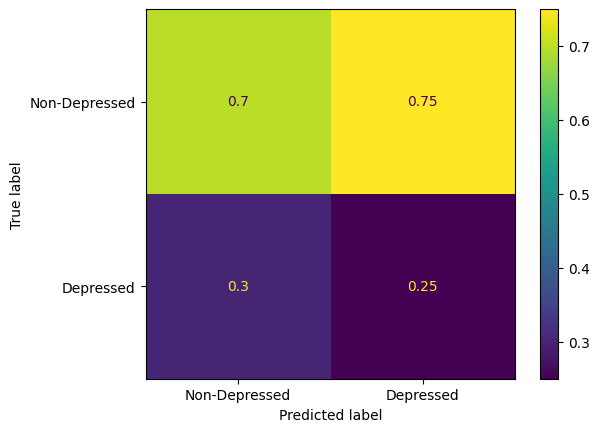

Accuracy = 0.4738372093023256
Recall = 0.45263157894736844
Precision = 0.25
F1-score = 0.3220973782771535


In [18]:
#Predict
x = [pose_test, lm_test]
y = y_test
# x = x_dev_bad
# y = y_dev_bad
y_pose_lm_prediction = model_pose_lm.predict(x)
y_pose_lm_prediction = np.argmax(y_pose_lm_prediction, axis = 1)
# print(sum(y_pose_prediction)/len(y_pose_prediction))
print(y_pose_lm_prediction)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y, y_pose_lm_prediction, normalize='pred')
print(result)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ["Non-Depressed", "Depressed"])
cm_display.plot()
plt.show()
tn_pose = result[0][0]
tp_pose = result[1][1]
fn_pose = result[1][0]
fp_pose = result[0][1]
accuracy = (tp_pose + tn_pose)/(tp_pose + tn_pose + fp_pose + fn_pose)
recall = tp_pose / (tp_pose + fn_pose)
precision = tp_pose / (tp_pose + fp_pose)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy = " + str(accuracy))
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1-score = " + str(f1_score))

In [ ]:
plot_model(model_pose_lm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

NameError: name 'model_pose' is not defined

In [ ]:
# model_pose.save("saved_models/good_pose_21_6")

INFO:tensorflow:Assets written to: saved_models/good_pose_21_6\assets


INFO:tensorflow:Assets written to: saved_models/good_pose_21_6\assets
